# 🌲 PINECONe Demo
## Pine Ecosystem Carbon and Economics RX Fire Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NASA-EarthRISE/PINECONe/blob/main/PINECONe_Demo.ipynb)

This notebook demonstrates the complete PINECONe workflow:
1. **Biomass Statistics** - Calculate above-ground biomass for focal species (e.g., Longleaf Pine)
2. **Carbon Emissions** - Estimate CO₂ emissions from biomass change
3. **Economic Valuation** - Calculate Total Economic Value (TEV) with uncertainty

---

**Author:** NASA EarthRISE  
**GitHub:** https://github.com/NASA-EarthRISE/PINECONe  
**License:** MIT


## 📦 Setup & Installation

First, we'll install the PINECONe package and authenticate with Google Earth Engine.

In [16]:
# Install PINECONe package
# Note: Replace with actual PyPI package when published
# For now, install from GitHub
!pip install git+https://github.com/NASA-EarthRISE/PINECONe.git -q

# Or for development, clone and install locally:
# !git clone https://github.com/NASA-EarthRISE/PINECONe.git
# !pip install -e ./PINECONe -q

print("✓ PINECONe installed successfully!")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.0 MB/s eta 0:00:00
✓ PINECONe installed successfully!


In [17]:
import ee
import geemap
import geemap.chart as chart
ee.Authenticate()
ee.Initialize(project='add your GEE project here') #### add your GEE project here
Map = geemap.Map()

## 📚 Import Libraries

In [18]:
# Import PINECONe modules
from pinecone.data.biomass import BiomassData
from pinecone.data.focal_species import FocalSpeciesLayer
from pinecone.carbon.biomass_stats import BiomassStatsCalculator
from pinecone.carbon.biomass_change import BiomassChangeCalculator
from pinecone.economics.tev_calculator import TEVCalculator, DEFAULT_ECONOMIC_PARAMS

# Other libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## ⚙️ Configuration

Set your analysis parameters here. You can modify these to analyze different regions, time periods, or species.

In [19]:
# =============================================================================
# USER CONFIGURATION - MODIFY THESE PARAMETERS
# =============================================================================

# 1. STUDY AREAS (Areas of Interest - AOIs)
# You can use pre-loaded example AOIs or upload your own
USE_EXAMPLE_AOIS = True  # Set to False to use your own

if USE_EXAMPLE_AOIS:
    # Example: EarthRISE case study areas in Alabama
    aois = {
        'EIA_CS1': ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS1'),
        'EIA_CS2': ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS2'),
        'EIA_CS3': ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS3')
    }

    # Acres for each AOI (for TEV calculation)
    case_acres = {
        'EIA_CS1_LLP': 651.06,
        'EIA_CS2_LLP': 937.02,
        'EIA_CS3_LLP': 544.03
    }
else:
    # Upload your own shapefile/geojson
    from google.colab import files
    uploaded = files.upload()
    # TODO: Add code to load uploaded files
    pass

# 2. FOCAL SPECIES LAYER
# Example: Longleaf Pine (LLP) significance layer
focal_species_asset = "projects/servir-sco-assets/assets/Rx_Fire/EO_Inputs/LEO_extantLLP_significance"
focal_species_name = "Longleaf Pine (LLP)"
focal_species_threshold = 0  # Values > threshold = species present

# 3. BIOMASS DATA SOURCE
biomass_product = 'esa_cci_agb'  # Options: 'esa_cci_agb', 'gedi_l4b', 'whrc'
biomass_year = 2019

# 4. TIME PERIODS FOR EMISSIONS ANALYSIS
pre_fire_start = '2018-01-01'
pre_fire_end = '2018-12-31'
post_fire_start = '2019-01-01'
post_fire_end = '2019-12-31'

# 5. CARBON & ECONOMIC PARAMETERS
carbon_fraction = 0.51  # Carbon content of biomass (default: 0.51)
carbon_credit_price = 10.0  # Price per ton CO2e ($/ton)
num_monte_carlo_sims = 10000  # Number of Monte Carlo simulations

print("✓ Configuration complete!")
print(f"  • Study areas: {len(aois)}")
print(f"  • Focal species: {focal_species_name}")
print(f"  • Biomass product: {biomass_product} ({biomass_year})")
print(f"  • Analysis period: {pre_fire_start} to {post_fire_end}")
print(f"  • Carbon credit price: ${carbon_credit_price}/ton CO2e")

✓ Configuration complete!
  • Study areas: 3
  • Focal species: Longleaf Pine (LLP)
  • Biomass product: esa_cci_agb (2019)
  • Analysis period: 2018-01-01 to 2019-12-31
  • Carbon credit price: $10.0/ton CO2e


## 📊 Script 1: Biomass Statistics

Calculate above-ground biomass (AGB) for focal species areas vs. non-focal species areas.

**What this does:**
- Loads biomass data from Earth Engine
- Identifies focal species (e.g., Longleaf Pine) areas
- Calculates biomass statistics for each area
- Separates focal species vs. non-focal species areas

In [20]:
# Initialize focal species layer
print("🌲 Loading focal species layer...")
focal_species = FocalSpeciesLayer(
    layer_source=focal_species_asset,
    binary_threshold=focal_species_threshold,
    name=focal_species_name
)
print(f"✓ Loaded: {focal_species.name}")

# Initialize biomass data
print(f"\n📊 Loading biomass data ({biomass_product}, {biomass_year})...")
biomass = BiomassData(
    product=biomass_product,
    year=biomass_year
)
print(f"✓ Loaded: {biomass.product} ({biomass.year})")

# Create biomass calculator
calculator_biomass = BiomassStatsCalculator(biomass)

🌲 Loading focal species layer...
✓ Loaded: Longleaf Pine (LLP)

📊 Loading biomass data (esa_cci_agb, 2019)...
✓ Loaded: esa_cci_agb (2019)


In [21]:
# Process each AOI
print("\n🔄 Processing AOIs...")
all_stats_list = []

for aoi_name, aoi_fc in aois.items():
    print(f"  Processing {aoi_name}...")

    # Vectorize focal species in this AOI
    species_vectors = focal_species.vectorize(aoi_fc, scale=30)
    species_dissolved = species_vectors.union(1)

    # Get non-species areas
    non_species = focal_species.get_non_species_areas(
        aoi_fc,
        species_dissolved.geometry()
    )

    # Calculate stats for both species and non-species areas
    stats_species = calculator_biomass.calculate_stats(
        species_vectors,
        f"{aoi_name}_LLP"
    )

    stats_non_species = calculator_biomass.calculate_stats(
        non_species,
        f"{aoi_name}_NonLLP"
    )

    # Merge results
    all_stats_list.append(stats_species.merge(stats_non_species))

# Combine all zones
all_stats = all_stats_list[0]
for stats in all_stats_list[1:]:
    all_stats = all_stats.merge(stats)

# Calculate zone summaries
zone_summary = calculator_biomass.calculate_zone_summary(all_stats)
biomass_results = zone_summary.getInfo()

print("\n✓ Biomass statistics calculated!")


🔄 Processing AOIs...
  Processing EIA_CS1...
  Processing EIA_CS2...
  Processing EIA_CS3...

✓ Biomass statistics calculated!



📈 BIOMASS STATISTICS RESULTS


,Zone,Mean AGB (tons/acre),Std Dev (tons/acre),Total Area (acres),Total Biomass (tons)
0,EIA_CS1_LLP,68.11,3.70,651.06,41391.59
1,EIA_CS1_NonLLP,93.84,0.10,627.46,58879.37
2,EIA_CS2_LLP,64.82,3.30,937.02,62438.39
3,EIA_CS2_NonLLP,68.95,0.03,1743.25,120196.25
4,EIA_CS3_LLP,46.05,0.14,544.03,25052.85
5,EIA_CS3_NonLLP,87.77,0.16,485.41,42603.40


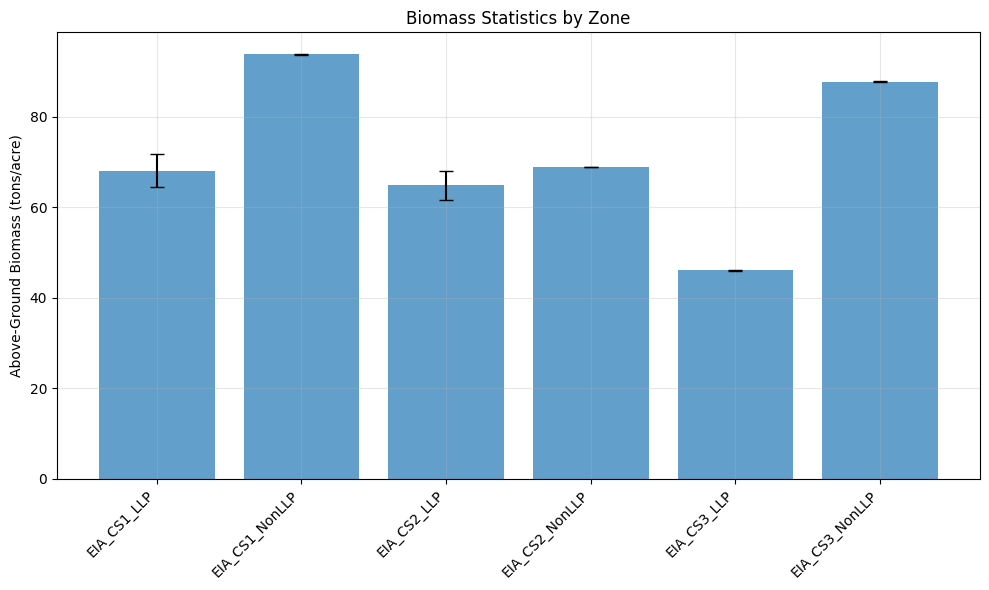

In [22]:
# Display results
print("\n📈 BIOMASS STATISTICS RESULTS")
print("="*60)

biomass_stats_dict = {}
results_data = []

for feature in biomass_results['features']:
    props = feature['properties']
    zone = props['AOI_Zone']

    results_data.append({
        'Zone': zone,
        'Mean AGB (tons/acre)': props['mean_AGB_per_acre_tons'],
        'Std Dev (tons/acre)': props['mean_StdDev_per_acre_tons'],
        'Total Area (acres)': props['total_area_acres'],
        'Total Biomass (tons)': props['total_biomass_tons']
    })

    if 'LLP' in zone:
        biomass_stats_dict[zone] = {
            'AGB_per_acre_tons': props['mean_AGB_per_acre_tons'],
            'AGB_StdDev_per_acre_tons': props['mean_StdDev_per_acre_tons']
        }

# Create DataFrame for display
biomass_df = pd.DataFrame(results_data)
display(biomass_df.style.format({
    'Mean AGB (tons/acre)': '{:.2f}',
    'Std Dev (tons/acre)': '{:.2f}',
    'Total Area (acres)': '{:.2f}',
    'Total Biomass (tons)': '{:.2f}'
}))

# Plot biomass comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(biomass_df))
ax.bar(x, biomass_df['Mean AGB (tons/acre)'],
       yerr=biomass_df['Std Dev (tons/acre)'],
       capsize=5, alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(biomass_df['Zone'], rotation=45, ha='right')
ax.set_ylabel('Above-Ground Biomass (tons/acre)')
ax.set_title('Biomass Statistics by Zone')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 💨 Script 2: Carbon Emissions

Calculate carbon emissions from biomass change between two time periods.

**What this does:**
- Compares biomass before and after fire events
- Applies quality filters to exclude improbable changes
- Converts biomass change to CO₂ emissions
- Calculates uncertainty using standard deviation

In [23]:
# Initialize emissions calculator
print("💨 Calculating carbon emissions...")
emissions_calculator = BiomassChangeCalculator(
    biomass_data=None,
    focal_species=focal_species,
    carbon_fraction=carbon_fraction,
    credit_price_per_ton=1.0  # Will multiply by actual price later
)

# Calculate emissions for all AOIs
emissions_fc = emissions_calculator.calculate_for_multiple_aois(
    aois=aois,
    pre_date_start=pre_fire_start,
    pre_date_end=pre_fire_end,
    post_date_start=post_fire_start,
    post_date_end=post_fire_end,
    resolution=100,
    apply_quality_filter=True
)

emissions_results = emissions_fc.getInfo()
print("\n✓ Carbon emissions calculated!")

💨 Calculating carbon emissions...
   Processing EIA_CS1...
      ✓ EIA_CS1: -97847.44 tons CO2
   Processing EIA_CS2...
      ✓ EIA_CS2: -88083.27 tons CO2
   Processing EIA_CS3...
      ✓ EIA_CS3: -63744.96 tons CO2

✓ Carbon emissions calculated!



📈 CARBON EMISSIONS RESULTS


,Zone,Area (acres),CO2 (tons/acre),Std Dev (tons/acre),Total CO2 (tons)
0,EIA_CS1_LLP,651.06,-150.29,94.71,-97847.44
1,EIA_CS2_LLP,937.02,-94.00,75.65,-88083.27
2,EIA_CS3_LLP,544.03,-117.17,75.89,-63744.96


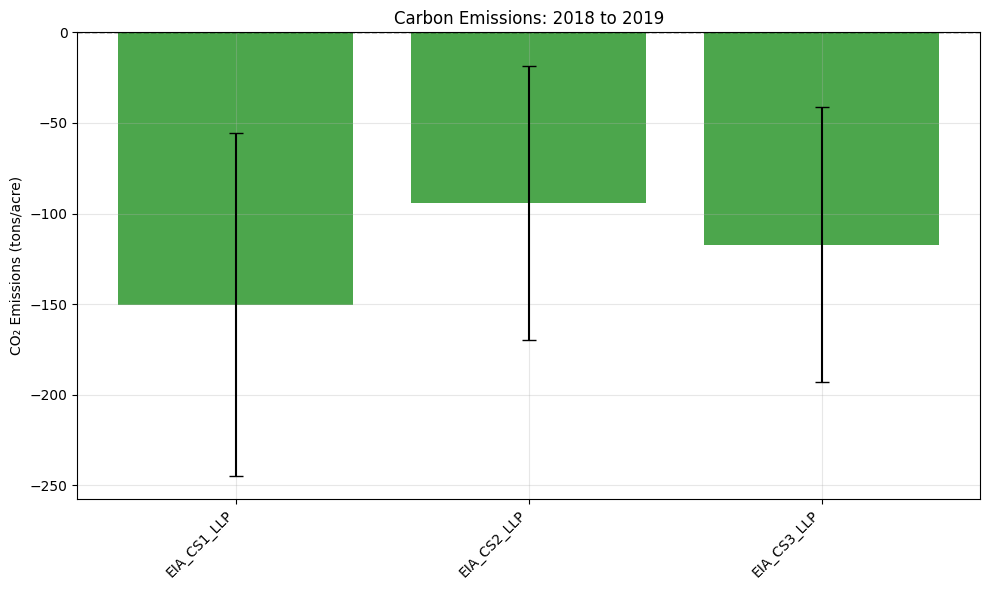


💡 Negative values = Carbon sequestration (biomass gain)
💡 Positive values = Carbon emissions (biomass loss)


In [24]:
# Display results
print("\n📈 CARBON EMISSIONS RESULTS")
print("="*60)

emissions_stats_dict = {}
emissions_data = []

for feature in emissions_results['features']:
    props = feature['properties']
    zone = props['AOI_Zone']
    zone_llp = f"{zone}_LLP"

    emissions_data.append({
        'Zone': zone_llp,
        'Area (acres)': props['area_acres'],
        'CO2 (tons/acre)': props['CO2_mean_tons_per_acre'],
        'Std Dev (tons/acre)': props.get('CO2_std_tons_per_acre', 0),
        'Total CO2 (tons)': props['CO2_total_tons']
    })

    emissions_stats_dict[zone_llp] = {
        'CO2_mean_tons_per_acre': props['CO2_mean_tons_per_acre'],
        'CO2_std_tons_per_acre': props.get('CO2_std_tons_per_acre', 0)
    }

# Create DataFrame
emissions_df = pd.DataFrame(emissions_data)
display(emissions_df.style.format({
    'Area (acres)': '{:.2f}',
    'CO2 (tons/acre)': '{:.2f}',
    'Std Dev (tons/acre)': '{:.2f}',
    'Total CO2 (tons)': '{:.2f}'
}))

# Plot emissions
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(emissions_df))
colors = ['green' if val < 0 else 'red' for val in emissions_df['CO2 (tons/acre)']]
ax.bar(x, emissions_df['CO2 (tons/acre)'],
       yerr=emissions_df['Std Dev (tons/acre)'],
       capsize=5, alpha=0.7, color=colors)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(emissions_df['Zone'], rotation=45, ha='right')
ax.set_ylabel('CO₂ Emissions (tons/acre)')
ax.set_title(f'Carbon Emissions: {pre_fire_start[:4]} to {post_fire_start[:4]}')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Negative values = Carbon sequestration (biomass gain)")
print("💡 Positive values = Carbon emissions (biomass loss)")

## 💰 Script 3: Total Economic Value (TEV)

Calculate the total economic value combining:
- Timber value
- Carbon credits
- Ecosystem services
- Land value (hunting/leases)

Uses Monte Carlo simulation to quantify uncertainty.

In [25]:
# Initialize TEV calculator
print("💰 Calculating Total Economic Value...")
tev_calculator = TEVCalculator(random_seed=42)

# Create input DataFrame from Scripts 1 & 2
input_df = tev_calculator.create_input_dataframe(
    biomass_stats=biomass_stats_dict,
    emissions_stats=emissions_stats_dict,
    carbon_credit_price=carbon_credit_price
)

print(f"\n📊 Running {num_monte_carlo_sims:,} Monte Carlo simulations...")
print("(This may take a minute...)")

# Run Monte Carlo simulations
tev_results = tev_calculator.run_monte_carlo(
    input_df=input_df,
    base_cases=DEFAULT_ECONOMIC_PARAMS,
    case_acres=case_acres,
    num_simulations=num_monte_carlo_sims
)

print("\n✓ TEV calculations complete!")

💰 Calculating Total Economic Value...

📊 Running 10,000 Monte Carlo simulations...
(This may take a minute...)

✓ TEV calculations complete!


In [26]:
# Display results
print("\n📈 TOTAL ECONOMIC VALUE (TEV) RESULTS")
print("="*60)

# Format results nicely
display_df = tev_results.copy()
display_df['Mean_TEV'] = display_df['Mean_TEV'].apply(lambda x: f"${x:,.0f}")
display_df['Std_TEV'] = display_df['Std_TEV'].apply(lambda x: f"±${x:,.0f}")
display_df['Median_TEV'] = display_df['Median_TEV'].apply(lambda x: f"${x:,.0f}")
display_df['Q25_TEV'] = display_df['Q25_TEV'].apply(lambda x: f"${x:,.0f}")
display_df['Q75_TEV'] = display_df['Q75_TEV'].apply(lambda x: f"${x:,.0f}")

display(display_df)


📈 TOTAL ECONOMIC VALUE (TEV) RESULTS


,Case,Method,Mean_TEV,Std_TEV,Median_TEV,Q25_TEV,Q75_TEV
0,EIA_CS1_LLP,ESA,"$-786,672","±$621,156","$-787,037","$-1,209,666","$-370,108"
1,EIA_CS2_LLP,ESA,"$628,968","±$731,931","$638,371","$133,148","$1,123,482"
2,EIA_CS3_LLP,ESA,"$1,959,393","±$427,023","$1,959,076","$1,667,374","$2,246,330"



📊 Generating visualizations...


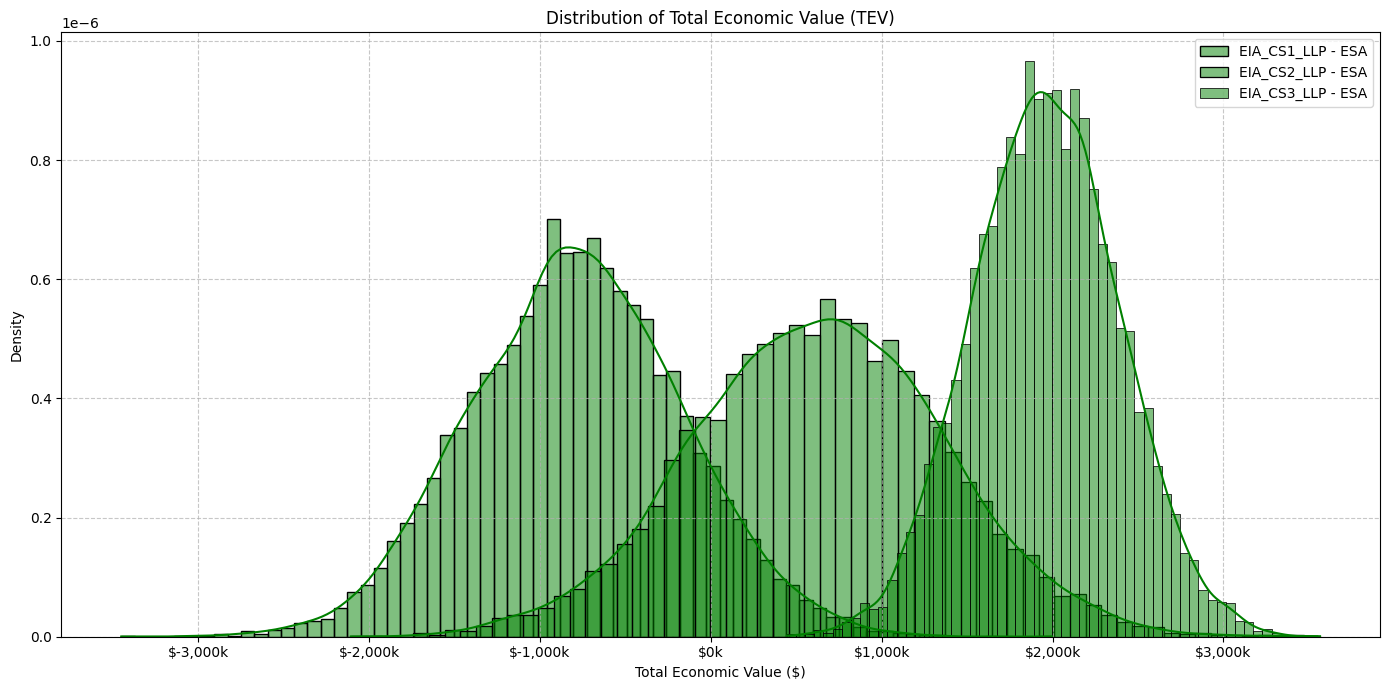

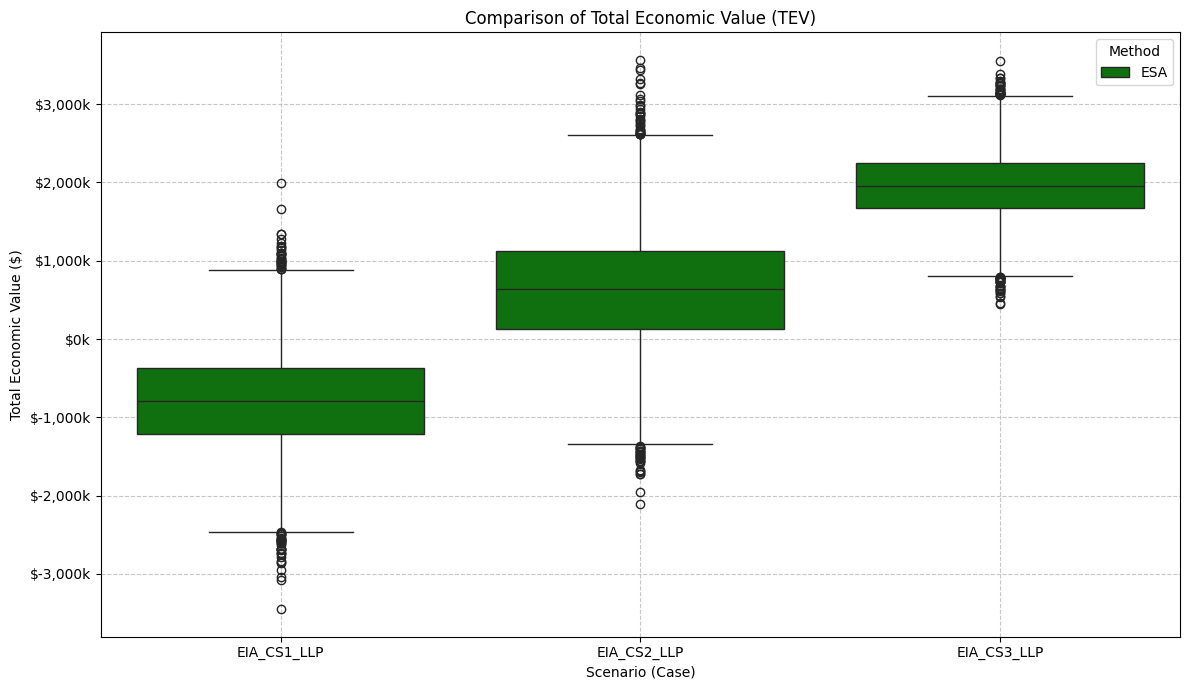

In [27]:
# Visualizations
print("\n📊 Generating visualizations...")

# Distribution plot
tev_calculator.plot_distributions(
    title='Distribution of Total Economic Value (TEV)'
)

# Boxplot comparison
tev_calculator.plot_boxplots(
    title='Comparison of Total Economic Value (TEV)'
)

## 💾 Export Results

Save your results to Google Drive or download as CSV files.

In [ ]:
# Mount Google Drive (optional)
from google.colab import drive
drive.mount('/content/drive')

# Set output directory
output_dir = '/content/drive/MyDrive/PINECONe_Results'

# Create directory if it doesn't exist
import os
os.makedirs(output_dir, exist_ok=True)

# Export biomass results
biomass_df.to_csv(f"{output_dir}/biomass_statistics.csv", index=False)
print(f"✓ Biomass results saved to {output_dir}/biomass_statistics.csv")

# Export emissions results
emissions_df.to_csv(f"{output_dir}/carbon_emissions.csv", index=False)
print(f"✓ Emissions results saved to {output_dir}/carbon_emissions.csv")

# Export TEV results
tev_results.to_csv(f"{output_dir}/tev_results.csv", index=False)
print(f"✓ TEV results saved to {output_dir}/tev_results.csv")

print(f"\n📁 All results saved to: {output_dir}")

## 📋 Summary

Congratulations! You've completed the PINECONe analysis workflow:

✅ **Script 1**: Calculated biomass statistics for focal species (LLP) vs. non-focal species  
✅ **Script 2**: Estimated carbon emissions from biomass change  
✅ **Script 3**: Calculated Total Economic Value (TEV) with uncertainty quantification  

---

### 🔧 Next Steps

- **Modify parameters** in the Configuration section to analyze different regions or time periods
- **Upload your own data** by setting `USE_EXAMPLE_AOIS = False`
- **Adjust economic parameters** in `DEFAULT_ECONOMIC_PARAMS` for different scenarios
- **Change carbon credit prices** to see sensitivity of TEV

### 📚 Resources

- **GitHub**: https://github.com/NASA-EarthRISE/PINECONe
- **Issues/Questions**: https://github.com/NASA-EarthRISE/PINECONe/issues

---

**Citation**: If you use PINECONe in your research, please cite:  
*[Citation information to be added]*
